# Data preparation

In this phase, we will create new variables or transform existing ones in order to better respond to our objective.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

# Data importation

In [2]:
con = sa.create_engine('sqlite:///DatosCaso1/airbnb.db')

df = pd.read_sql_table('df', con)
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,...,f,1,1.0,1.0,33,4.58,4.82,4.21,3116,Latina
1,1,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,Centro,Justicia,40.41884,-3.69655,Private room,69.0,...,f,4,1.0,2.0,219,4.64,4.85,4.97,6739,Centro
2,2,70073,Adorable Apartment Malasaña-Gran Via,353738,Centro,Universidad,40.42252,-3.70250,Entire home/apt,80.0,...,f,2,1.0,1.0,35,4.21,4.38,4.59,6739,Centro
3,3,70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",353738,Centro,Universidad,40.42252,-3.70250,Entire home/apt,64.0,...,f,2,1.0,2.0,29,4.36,4.69,4.86,6739,Centro
4,4,72150,Sunny attic duplex flat with terrace next to Sol,364585,Centro,Embajadores,40.41150,-3.70449,Entire home/apt,159.0,...,t,6,3.0,5.0,121,4.61,4.84,4.84,6739,Centro


# Variable preparation

First, we will create the analysis variables:

* Price per night: we already have this directly in the price variable, but let's review it to make sure we understand it correctly.
* Occupancy: we have availability_365, but we need to transform it.
* Property price: we will have to create this with external variables, so we will leave it for later.

**Let's start with the price.**

The documentation does not clarify whether the price is for the entire property or, in the case of renting a room, per room. This is key information for assessing the potential income from a property.

Let's try to understand this by analyzing the average price per type of rental.

In [3]:
df.distrito.value_counts()

distrito
Centro                   8654
Salamanca                1406
Tetuán                   1352
Chamberí                 1266
Arganzuela               1070
Carabanchel               764
Ciudad Lineal             758
Retiro                    731
Chamartín                 671
Puente de Vallecas        666
Latina                    530
Moncloa - Aravaca         506
Usera                     501
Hortaleza                 424
San Blas - Canillejas     410
Fuencarral - El Pardo     288
Villaverde                183
Barajas                   144
Moratalaz                 128
Villa de Vallecas         114
Vicálvaro                  68
Name: count, dtype: int64

In [4]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.mean()

room_type
Entire home/apt    159.852449
Private room        85.214505
Shared room         96.500000
Name: price, dtype: float64

Conclusion:

* Renting an apartment has an average price of €160.
* Renting a room has an average price of €96 or €85, depending on whether it is shared or private.
* Therefore, to calculate the “income” of a property, we must multiply the price by the number of rooms when it is a private room or shared room.

However, multiplying the price by the total number of rooms can artificially inflate a property's revenue-generating capacity.
This is because if it is rented by the room, it is unlikely to always be at 100% occupancy. Therefore, we should weight it by the average percentage of rooms rented.

We do not have that data, but let's assume that we have spoken to the business manager and they have told us that it is 70%.
We can create the total price variable by applying a custom function.

In [9]:
def total_price(register):
    if (register.beds > 1) & ((register.room_type == 'Private room') | (register.room_type == 'Shared room')):
        exit = register.price * register.beds * 0.7
    else:
        exit = register.price
    return(exit)

df['total_price'] = df.apply(total_price, axis = 1)

In [10]:
df[['room_type','price','beds','total_price']].head(30)

,room_type,price,beds,total_price
0,Private room,31.0,1.0,31.0
1,Private room,69.0,2.0,96.6
2,Entire home/apt,80.0,1.0,80.0
3,Entire home/apt,64.0,2.0,64.0
4,Entire home/apt,159.0,5.0,159.0
5,Entire home/apt,80.0,1.0,80.0
6,Private room,53.0,1.0,53.0
7,Entire home/apt,155.0,1.0,155.0
8,Entire home/apt,65.0,2.0,65.0
9,Private room,20.0,1.0,20.0


**Now let's move on to occupancy.**

The variable we have that allows us to measure this is availability_365.

This variable tells us the number of days in a year that the property is NOT occupied.

Therefore, we would like to transform it into a more direct measure of occupancy, for example, the percentage of the year that it IS occupied.

In [12]:
df['occupancy'] = ((365 - df.availability_365) / 365 * 100).astype('int')
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total,total_price,ocupacion,occupancy
0,0,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,...,33,4.58,4.82,4.21,3116,Latina,31.0,31.0,60,60
1,1,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,Centro,Justicia,40.41884,-3.69655,Private room,69.0,...,219,4.64,4.85,4.97,6739,Centro,96.6,96.6,9,9
2,2,70073,Adorable Apartment Malasaña-Gran Via,353738,Centro,Universidad,40.42252,-3.70250,Entire home/apt,80.0,...,35,4.21,4.38,4.59,6739,Centro,80.0,80.0,25,25
3,3,70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",353738,Centro,Universidad,40.42252,-3.70250,Entire home/apt,64.0,...,29,4.36,4.69,4.86,6739,Centro,64.0,64.0,18,18
4,4,72150,Sunny attic duplex flat with terrace next to Sol,364585,Centro,Embajadores,40.41150,-3.70449,Entire home/apt,159.0,...,121,4.61,4.84,4.84,6739,Centro,159.0,159.0,50,50


# Variable transformations

Some of the seed questions are designed to check how price or occupancy behaves according to other variables such as the number of rooms, average ratings, etc. We can usually perform these analyses better if we discretize the analysis variable.

In our case, the candidates for this analysis are: accommodates, bedrooms, beds, and number_of_reviews. A more personalized discretization makes sense for bedrooms. For the others, we can do it automatically.

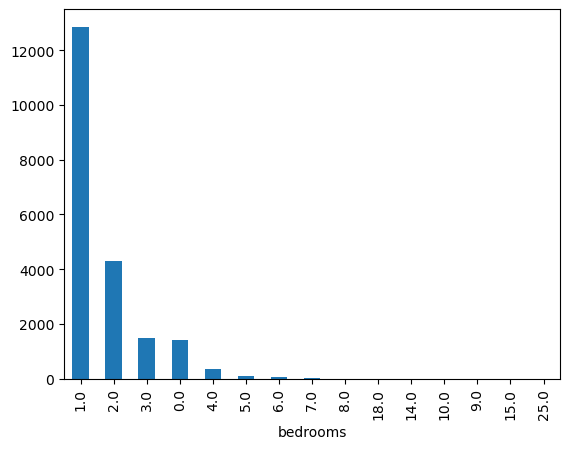

In [19]:
df.bedrooms.value_counts().plot.bar();

In [ ]:
conditions = [df.bedrooms == 0,
              df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

results = ['00_Zero','01_One','02_Two','03_Three','04_Four or more']

df['bedrooms_disc'] = np.select(conditions, results, default = -999)

In [23]:
df.bedrooms_disc.value_counts()

bedrooms_disc
01_One             12859
02_Two              4297
03_Three            1505
00_Zero             1416
04_Four or more      557
Name: count, dtype: int64

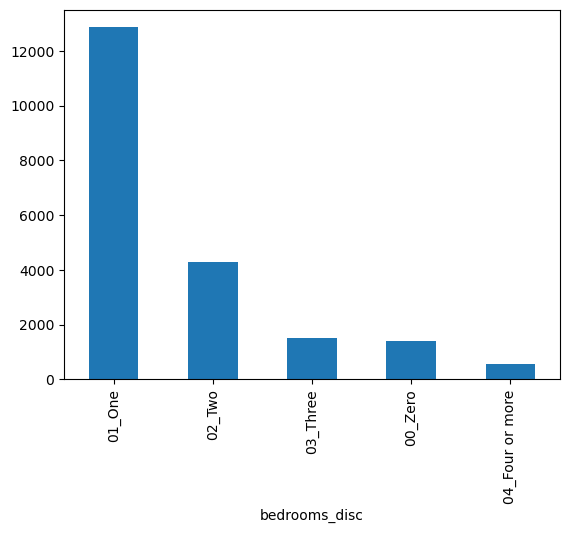

In [24]:
df.bedrooms_disc.value_counts().plot.bar();

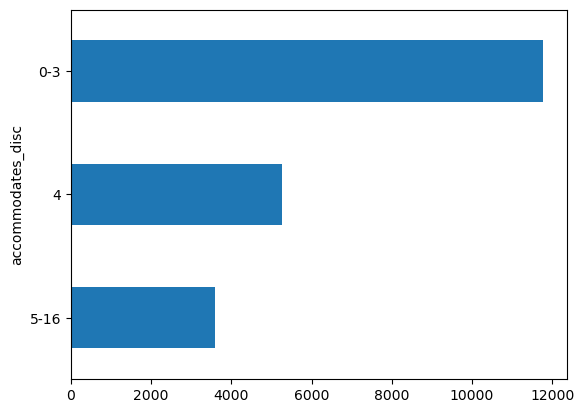

In [25]:
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.5, 0.8, 1],
                                 labels = ['0-3','4','5-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh();

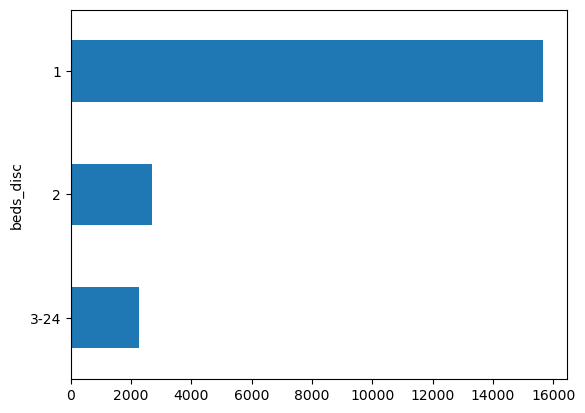

In [26]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

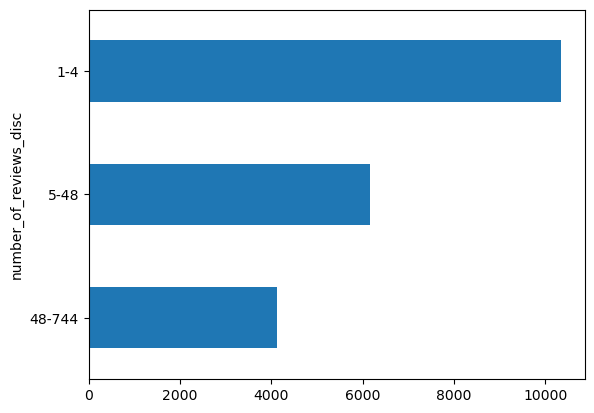

In [27]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

# New variables with external data

**Estimating the square footage of the property**

* zero bedroom: m2 = 40
* one bedroom: m2 = 50
* two bedrooms: m2 = 70
* three bedrooms: m2 = 90
* four bedrooms: m2 = 120
* five or more bedrooms: m2 = 150

In [28]:
conditions = [df.bedrooms == 0, 
               df.bedrooms == 1, 
               df.bedrooms == 2, 
               df.bedrooms == 3, 
               df.bedrooms == 4, 
               df.bedrooms >4]
results = [40, 50, 70, 90, 120, 150]

df['m2'] = np.select(conditions, results, default = -999)

In [29]:
df['m2'].value_counts()

m2
50     12859
70      4297
90      1505
40      1416
120      347
150      210
Name: count, dtype: int64

Now we can estimate the purchase price of the property.

We subtracted 30% from the price we arrived at due to our negotiating power.

In [31]:
df['price'] = df.m2 * df.precio_m2 * 0.7

In [32]:
df[['bedrooms','m2','distrito','precio_m2','price']].head(20)

,bedrooms,m2,distrito,precio_m2,price
0,1.0,50,Latina,3116,109060.0
1,1.0,50,Centro,6739,235865.0
2,1.0,50,Centro,6739,235865.0
3,1.0,50,Centro,6739,235865.0
4,3.0,90,Centro,6739,424557.0
5,1.0,50,Centro,6739,235865.0
6,1.0,50,Centro,6739,235865.0
7,1.0,50,Salamanca,8993,314755.0
8,2.0,70,Centro,6739,330211.0
9,1.0,50,Latina,3116,109060.0


**Calculating the distance of each property from Puerta del Sol**

Given the curvature of the Earth, the distance between two points based on their latitude and longitude is calculated using a formula called the Haversine distance.

A Google search gives us a ready-made function to calculate it that we can adapt: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

Latitude: 40.4167278
Longitude: -3.7033387

In [33]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #In km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [ ]:
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda register: haversine(lat1,lon1,register.latitude,register.longitude),axis = 1)

In [35]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.722803
Arganzuela                1.946669
Chamberí                  2.152637
Retiro                    2.463231
Salamanca                 2.756522
Moncloa - Aravaca         3.547756
Latina                    3.759888
Carabanchel               3.906729
Usera                     3.979570
Puente de Vallecas        4.534852
Chamartín                 4.610590
Tetuán                    4.673430
Moratalaz                 4.978979
Ciudad Lineal             5.144995
Villaverde                7.683506
Fuencarral - El Pardo     7.912202
Hortaleza                 8.072138
San Blas - Canillejas     8.511902
Vicálvaro                 9.171654
Villa de Vallecas         9.209966
Barajas                  11.543476
Name: pdi_sol, dtype: float64

# Save df

In [36]:
df.to_sql('df_ready', con = con, if_exists = 'replace')

20634